In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import make_scorer, f1_score, precision_score,accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score


In [2]:
selected_ticker = ['SNA','VICI','UHS','BWA','MRO']
df_dict = {}
for i in selected_ticker:
    df_dict[i] = pd.read_csv(f'./stock_dfs2/{i}_2.csv')

In [3]:
# def add_feature(f):
#     n = 7
#     f['loc_min'] = f.iloc[argrelextrema(f.Close.values, np.less_equal, order=n)[0]]['Close']
#     f['loc_max'] = f.iloc[argrelextrema(f.Close.values, np.greater_equal, order=n)[0]]['Close']
#     f['hold'] = ~f.index.isin(f['loc_min'].dropna().index) & ~f.index.isin(f['loc_max'].dropna().index)
#     f['label'] = 0  
#     f.loc[f['loc_min'].notna(), 'label'] = 1
#     f.loc[f['loc_max'].notna(), 'label'] = 2
#     return f

def add_feature(f):

    f['price_diff'] = f['Close'].diff()
    f['label'] = 0
    
    # Assign labels based on the direction of the price change
    f.loc[f['price_diff'] > 0, 'label'] = 1  # Price went up
    f.loc[f['price_diff'] < 0, 'label'] = 0  # Price went down
    f.drop(columns=['price_diff'], inplace=True)
    
    return f
def gambar(f,target='label'):
    f['Date'] = pd.to_datetime(f['Date'], utc=True)
    plt.figure(figsize=(12, 6))
    plt.plot(f['Date'], f['Close'], label='Close Price', color='black')
    plt.scatter(f['Date'][f[target] == 0], f['Close'][f[target] == 0], 
               color='green', label='Label 0 (Beli / Harga turun)', marker='o')
    plt.scatter(f['Date'][f[target] == 1], f['Close'][f[target] == 1], 
               color='red', label='Label 1 (Jual / Harga naik)', marker='o')

    plt.title('Price Chart with Labels')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# def split_data(f):
#     f['Date'] = pd.to_datetime(f['Date'],utc=True)
#     f = f.sort_values(by='Date')
#     train_ratio = 0.85
#     split_index = int(len(f) * train_ratio)
#     train_data = f.iloc[:split_index]
#     test_data = f.iloc[split_index:]
#     print(f"Training data size: {len(train_data)}")
#     print(f"Test data size: {len(test_data)}")
#     return train_data, test_data

In [4]:
def add_technical_indicators(df, window=10):
    df = df.copy()
    
    df['SMA'] = df['Close'].rolling(window=window).mean()
    
    weights = np.arange(1, window + 1)
    df['WMA'] = df['Close'].rolling(window).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True
    )
    
    df['Momentum'] = df['Close'].diff(window)
    
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    df['Stochastic_K'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=window).mean()
    
    change = df['Close'].diff(1)
    gain = (change.where(change > 0, 0)).rolling(window=window).mean()
    loss = (-change.where(change < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['Williams_R'] = ((high_max - df['Close']) / (high_max - low_min)) * -100
    
    df['A/D_Oscillator'] = ((df['High'] - df['Close'].shift(1)) / 
                           (df['High'] - df['Low']))
    
    mean_deviation = lambda x: np.mean(np.abs(x - np.mean(x)))
    df['CCI'] = ((df['Close'] - df['Close'].rolling(window=window).mean()) / 
                 (0.015 * df['Close'].rolling(window=window).apply(mean_deviation, raw=True)))
    
    return df

def add_date_features(df):
    if 'Date' not in df.columns:
        raise ValueError("DataFrame harus mengandung kolom 'Date'.")
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        raise TypeError("Kolom 'Date' harus bertipe datetime.")

    # Menambahkan kolom 'day' yang berisi hari dalam bulan
    df['day'] = df['Date'].dt.day

    # Menambahkan kolom 'day_of_week' yang berisi hari dalam minggu (0=Senin, 6=Minggu)
    df['day_of_week'] = df['Date'].dt.dayofweek

    # Menambahkan kolom 'month' yang berisi bulan
    df['month'] = df['Date'].dt.month

    # Menambahkan kolom 'year' yang berisi tahun
    df['year'] = df['Date'].dt.year

    return df

features = ['SMA', 'WMA',
       'Momentum', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD',
       'MACD_Signal', 'Williams_R', 'A/D_Oscillator', 'CCI']

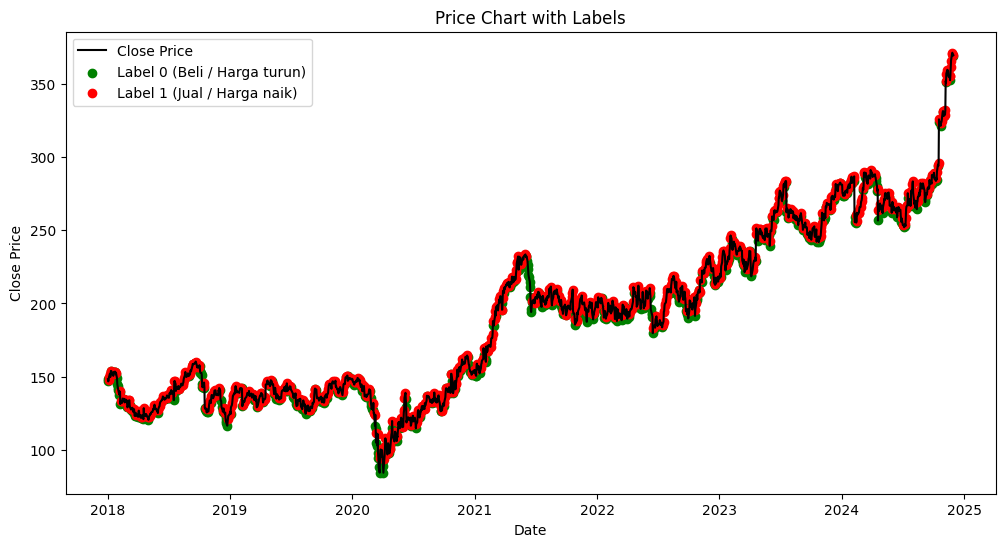

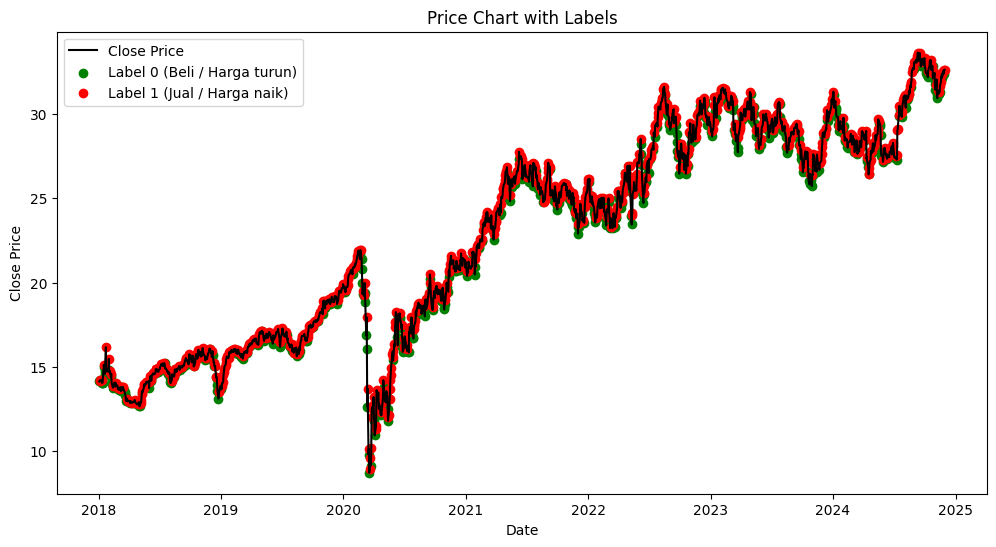

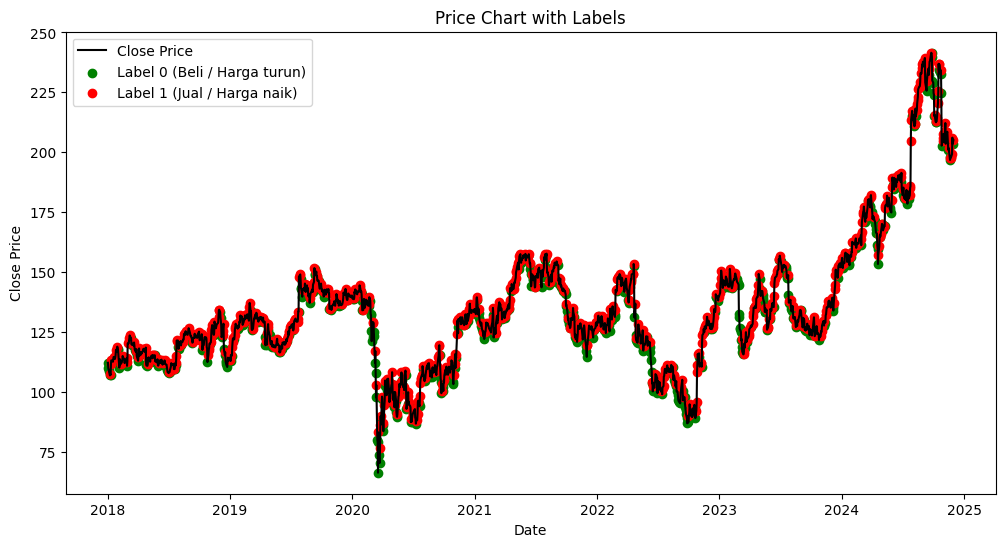

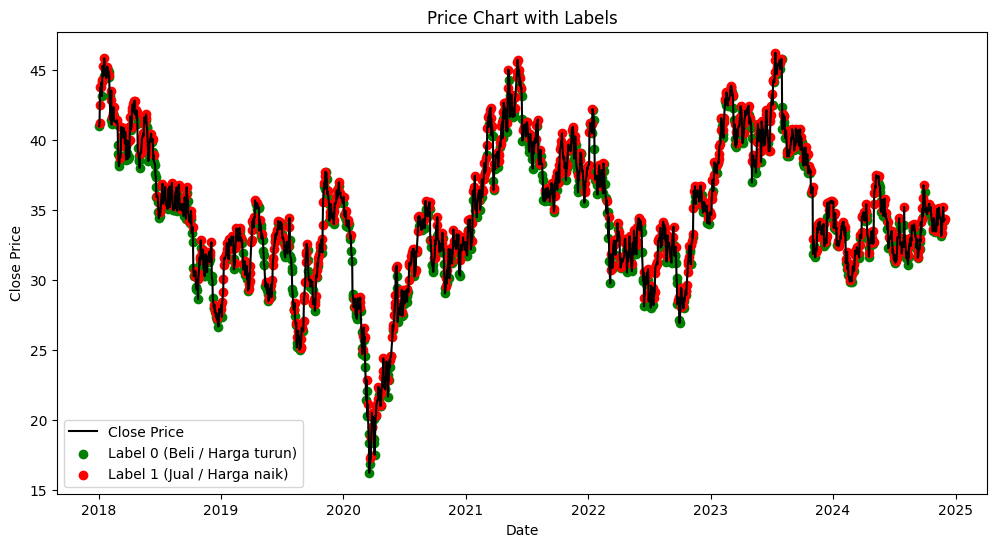

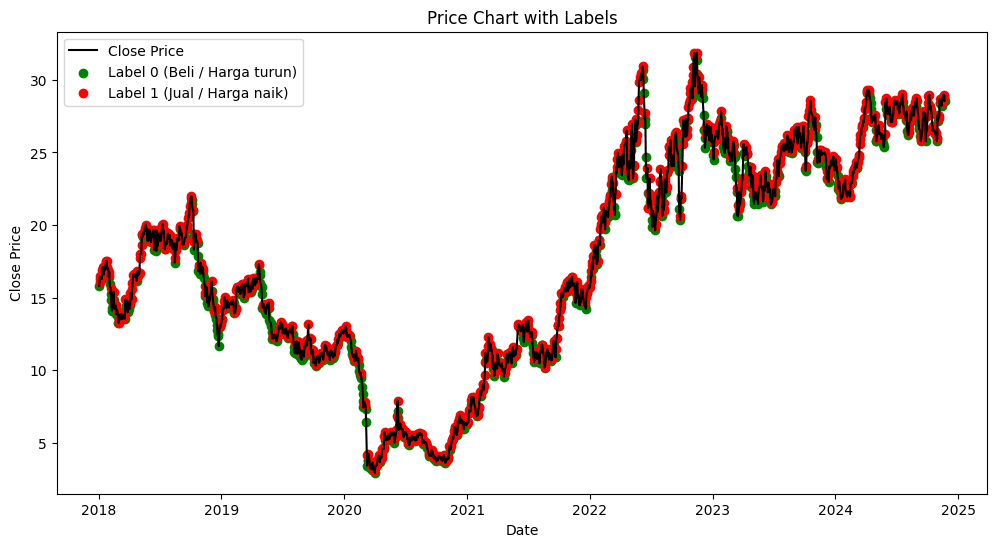

In [5]:
for i in df_dict:
    df_dict[i]['Date'] = pd.to_datetime(df_dict[i]['Date'],utc=True)
    df_dict[i] = add_feature(df_dict[i])
    df_dict[i] = add_date_features(df_dict[i])
    df_dict[i] = add_technical_indicators(df_dict[i])
    gambar(df_dict[i])


# SNA

In [6]:
df_dict['SNA'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,146.242915,148.345498,144.324611,148.177963,727700,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,148.002125,148.253433,145.480698,146.753983,434800,0.0,0.0,0,3,...,NaN,NaN,NaN,NaN,NaN,-0.113594,-0.022719,NaN,0.027218,NaN
2,2018-01-04 05:00:00+00:00,147.331952,148.127750,146.645045,147.574875,432400,0.0,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,-0.135813,-0.045338,NaN,0.926528,NaN
3,2018-01-05 05:00:00+00:00,148.043999,149.677481,147.667043,149.484818,407800,0.0,0.0,1,5,...,NaN,NaN,NaN,NaN,NaN,0.000686,-0.036133,NaN,1.045845,NaN
4,2018-01-08 05:00:00+00:00,149.208355,152.198894,148.739253,152.014603,1454300,0.0,0.0,1,8,...,NaN,NaN,NaN,NaN,NaN,0.309429,0.032980,NaN,0.784497,NaN


In [7]:
X_train = df_dict['SNA'].dropna(subset=features)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   label           1722 non-null   int64              
 9   day             1722 non-null   int64              
 10  day_of_week     1722 non-null   int64              
 11  month           1722 non-null   int64              
 12  year            1722 non-null   int64              
 13  SMA             1722 non-null   

In [8]:
y_train = X_train['label']  
X_train = X_train.drop(columns=['label','Date','Dividends','Stock Splits'])

In [9]:
X_train

,Open,High,Low,Close,Volume,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,150.783167,152.014564,148.881620,149.032410,772500,29,0,1,2018,151.976062,151.896255,-4.758087,2.482846,52.601406,32.469000,0.791776,1.003581,-97.517154,-0.208579,-178.014497
19,147.533019,147.533019,143.512143,144.827301,1206600,30,1,1,2018,151.324345,150.596480,-6.517166,12.381709,47.481436,28.743160,0.195320,0.841929,-87.618291,-0.372902,-227.220530
20,145.673323,146.108922,143.218913,143.503723,765100,31,2,1,2018,150.498392,149.174549,-8.259537,2.609339,41.386493,24.561557,-0.379799,0.597583,-97.390661,0.443466,-164.987183
21,142.481723,143.805266,141.694298,142.305817,698800,1,3,2,2018,149.670760,147.684990,-8.276321,4.915893,37.363224,24.536189,-0.921623,0.293742,-95.084107,0.142846,-129.115829
22,141.258746,142.071301,139.482846,140.638855,792800,2,4,2,2018,148.422610,146.042826,-12.481491,7.890263,31.068479,9.422712,-1.468603,-0.058727,-92.109737,-0.090601,-115.753493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,362.140015,367.119995,361.070007,365.970001,593000,22,4,11,2024,357.843665,358.326639,8.848633,93.323743,79.016013,67.453320,13.134609,13.699128,-6.676257,0.945457,179.009024
1736,367.500000,372.940002,367.500000,370.640015,584300,25,0,11,2024,358.939069,360.653248,10.954041,90.019639,78.373148,69.949202,13.459408,13.651184,-9.980361,1.281250,182.656989
1737,369.010010,372.029999,367.660004,371.350006,442500,26,1,11,2024,360.254575,362.909782,13.155060,93.100513,78.503038,74.659143,13.617135,13.644374,-6.899487,0.318075,130.495873
1738,371.920013,373.899994,369.010010,369.230011,273000,27,2,11,2024,361.267627,364.541680,10.130524,80.545895,77.576053,68.162057,13.416413,13.598782,-19.454105,0.521472,82.293715


In [10]:
y_train.value_counts()

1    912
0    810
Name: label, dtype: int64

In [163]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [164]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [11]:
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [ ]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='Accuracy',  # Mengubah fitur utama untuk refit menjadi 'accuracy'
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_accuracy = grid_search.cv_results_['mean_test_Accuracy'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Accuracy': mean_accuracy,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")


In [ ]:
results_df

,Model,Scaler,Parameters,Mean Accuracy,Mean Recall,Mean Precision,Mean F1 Score
0,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.474564,0.500000,0.237282,0.321756
1,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.525436,0.500000,0.262718,0.344379
2,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.770732,0.769482,0.771881,0.769276
3,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.754704,0.749353,0.778380,0.745892
4,Logistic Regression,StandardScaler,"{'classifier__C': 0.01, 'classifier__penalty':...",0.862021,0.862161,0.861812,0.861638
...,...,...,...,...,...,...,...
3499,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.864808,0.863962,0.864765,0.864184
3500,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.867596,0.866961,0.867581,0.867023
3501,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.866202,0.865725,0.866008,0.865688
3502,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.866899,0.866413,0.866734,0.866366


In [ ]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result_2/SNA_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Accuracy  \
0  {'classifier__C': 0.001, 'classifier__penalty'...       0.474564   
1  {'classifier__C': 0.001, 'classifier__penalty'...       0.525436   
2  {'classifier__C': 0.001, 'classifier__penalty'...       0.770732   
3  {'classifier__C': 0.001, 'classifier__penalty'...       0.754704   
4  {'classifier__C': 0.01, 'classifier__penalty':...       0.862021   

   Mean Recall  Mean Precision  Mean F1 Score  
0     0.500000        0.237282       0.321756  
1     0.500000        0.262718       0.344379  
2     0.769482        0.771881       0.769276  
3     0.749353        0.778380       0.745892  
4     0.862161        0.861812       0.861638  


In [ ]:
results_df

,Model,Scaler,Parameters,Mean Accuracy,Mean Recall,Mean Precision,Mean F1 Score
0,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.474564,0.500000,0.237282,0.321756
1,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.525436,0.500000,0.262718,0.344379
2,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.770732,0.769482,0.771881,0.769276
3,Logistic Regression,StandardScaler,"{'classifier__C': 0.001, 'classifier__penalty'...",0.754704,0.749353,0.778380,0.745892
4,Logistic Regression,StandardScaler,"{'classifier__C': 0.01, 'classifier__penalty':...",0.862021,0.862161,0.861812,0.861638
...,...,...,...,...,...,...,...
3499,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.864808,0.863962,0.864765,0.864184
3500,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.867596,0.866961,0.867581,0.867023
3501,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.866202,0.865725,0.866008,0.865688
3502,Random Forest,No Scaler,"{'classifier__max_depth': 30, 'classifier__min...",0.866899,0.866413,0.866734,0.866366


In [ ]:
# results_df['Model'].value_counts().index

Index(['XGBoost', 'Random Forest', 'Logistic Regression'], dtype='object')

In [ ]:
for i in results_df['Model'].value_counts().index:
    print(i,results_df[results_df['Model'] == i]['Mean Accuracy'].max())

XGBoost 0.8794425087108013
Random Forest 0.873170731707317
Logistic Regression 0.9616724738675959


In [ ]:
results_df['Mean Accuracy'].max()

0.9616724738675959

In [ ]:
results_df['Mean F1 Score'].max()

0.9615996990531999

## feature selection

In [12]:
from sklearn.model_selection import cross_validate
import datetime

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])


def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_acc = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            accuracy = cv_results['test_Accuracy'].mean()
            if accuracy > best_acc:
                best_acc = accuracy
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': cv_results['test_F1_Score'].mean(),
                    'Accuracy':accuracy
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score'],
                'Accuracy': best_metrics['Accuracy']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | akurasi: {best_metrics['Accuracy']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

n_features_to_select = 20  # Tentukan jumlah fitur yang ingin dipilih
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result_2/SNA_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 20 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'A/D_Oscillator' | akurasi: 0.8585

Memilih fitur ke-2 dari 19 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'CCI' | akurasi: 0.8718

Memilih fitur ke-3 dari 18 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'month' | akurasi: 0.8704

Memilih fitur ke-4 dari 17 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'Stochastic_K' | akurasi: 0.8704

Memilih fitur ke-5 dari 16 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'Williams_R' | akurasi: 0.8704

Memilih fitur ke-6 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'day' | akurasi: 0.8690

Memilih fitur ke-7 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'SMA' | akurasi: 0.8690

Memilih fitur ke-8 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'Open' | akurasi: 0.8941

Memilih fitur ke-9 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'Close' | akurasi: 0.9275

Memilih fitur

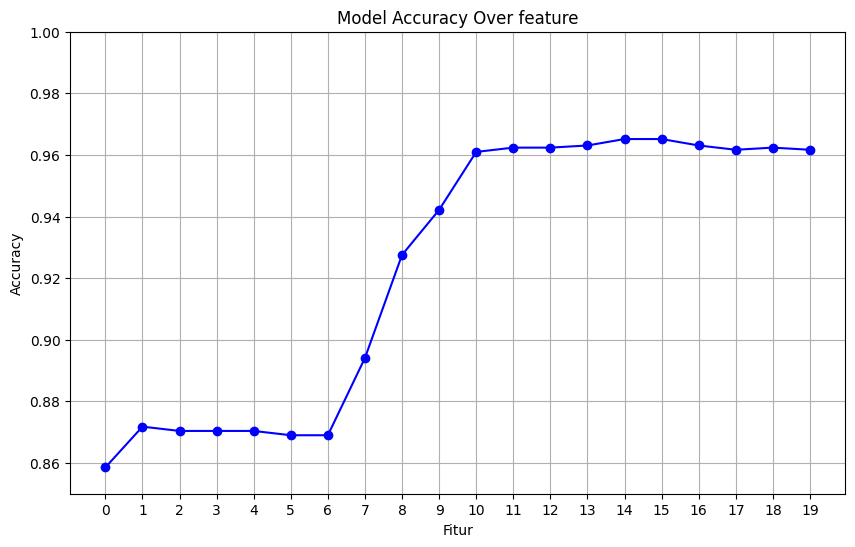

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['Accuracy'], marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Over feature')
plt.xlabel('Fitur')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(history_df.index)  # Ensure all epochs are shown on the x-axis
plt.ylim(0.85, 1.0)  # Set y-axis limits for better visualization
plt.show()

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])
```
dan feature 'A/D_Oscillator', 'CCI', 'month', 'Stochastic_K', 'Williams_R', 'day', 'SMA', 'Open', 'Close', 'Low', 'High', 'MACD_Signal', 'WMA', 'Stochastic_D', 'RSI' , dengan nilai Akurasi berupa 0.9652

# VICI

In [15]:
df_dict['VICI'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,14.061208,14.483045,14.026056,14.131515,427900,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,14.412739,14.483045,14.061209,14.173698,231300,0.0,0.0,1,3,...,NaN,NaN,NaN,NaN,NaN,0.003365,0.000673,NaN,0.833334,NaN
2,2018-01-04 05:00:00+00:00,14.166670,14.412742,14.131518,14.201824,447800,0.0,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,0.008207,0.002180,NaN,0.850011,NaN
3,2018-01-05 05:00:00+00:00,14.201824,14.201824,14.166670,14.201824,78300,0.0,0.0,0,5,...,NaN,NaN,NaN,NaN,NaN,0.011907,0.004125,NaN,0.000000,NaN
4,2018-01-08 05:00:00+00:00,14.201824,14.201824,14.096364,14.201824,59200,0.0,0.0,0,8,...,NaN,NaN,NaN,NaN,NaN,0.014670,0.006234,NaN,0.000000,NaN


In [16]:
X_train_vici = df_dict['VICI'].dropna(subset=features)
X_train_vici.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   label           1722 non-null   int64              
 9   day             1722 non-null   int64              
 10  day_of_week     1722 non-null   int64              
 11  month           1722 non-null   int64              
 12  year            1722 non-null   int64              
 13  SMA             1722 non-null   

In [17]:
y_train = X_train_vici['label']  
X_train = X_train_vici.drop(columns=['label','Date','Dividends','Stock Splits'])

In [18]:
X_train

,Open,High,Low,Close,Volume,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,14.483050,14.834580,14.483050,14.834580,24900,29,0,1,2018,14.950582,14.909358,0.780401,45.845433,50.573072,58.246682,0.199932,0.183358,-54.154567,0.000000,-27.847270
19,14.799423,14.834577,14.764271,14.799423,40100,30,1,1,2018,14.918944,14.881874,-0.316379,44.412600,49.283671,45.730547,0.188093,0.184305,-55.587400,-0.000048,-30.965546
20,14.799427,16.149303,14.693968,15.467335,643200,31,2,1,2018,14.969565,14.981582,0.506207,71.633361,51.346723,56.000024,0.229954,0.193435,-28.366639,0.927539,98.088480
21,14.820516,14.996281,14.532262,14.686934,24638300,1,3,2,2018,14.961831,14.930194,-0.077334,39.828117,51.031549,49.194756,0.197877,0.194323,-60.171883,-1.015158,-53.679258
22,14.588508,14.834580,14.342437,14.771304,4923100,2,4,2,2018,14.980112,14.895553,0.182801,43.266605,51.776559,51.940349,0.177221,0.190903,-56.733395,0.300005,-41.666310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,32.500000,32.599998,32.139999,32.230000,3346500,22,4,11,2024,31.759000,31.975091,0.840000,77.018681,61.809667,74.418592,-0.070297,-0.206302,-22.981319,0.500000,77.149873
1736,32.259998,32.705002,32.240002,32.529999,6375900,25,0,11,2024,31.884000,32.115272,1.249998,89.795753,68.050109,82.722433,-0.015963,-0.168234,-10.204247,1.021510,104.734024
1737,32.459999,32.529999,32.320000,32.380001,3589500,26,1,11,2024,32.002000,32.205454,1.180000,81.049541,73.763754,79.797994,0.014823,-0.131623,-18.950459,0.000000,68.553011
1738,32.450001,32.875000,32.439999,32.599998,4634200,27,2,11,2024,32.131000,32.314181,1.289999,85.411061,78.617709,80.861246,0.056324,-0.094034,-14.588939,1.137925,101.251882


In [19]:
y_train.value_counts()

1    911
0    811
Name: label, dtype: int64

In [177]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [178]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [20]:
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [180]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='Accuracy',  # Mengubah fitur utama untuk refit menjadi 'accuracy'
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_accuracy = grid_search.cv_results_['mean_test_Accuracy'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Accuracy': mean_accuracy,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")

Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [181]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result_2/VICI_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Accuracy  \
0  {'classifier__C': 0.001, 'classifier__penalty'...       0.470383   
1  {'classifier__C': 0.001, 'classifier__penalty'...       0.529617   
2  {'classifier__C': 0.001, 'classifier__penalty'...       0.761672   
3  {'classifier__C': 0.001, 'classifier__penalty'...       0.754007   
4  {'classifier__C': 0.01, 'classifier__penalty':...       0.753310   

   Mean Recall  Mean Precision  Mean F1 Score  
0     0.500000        0.235192       0.319669  
1     0.500000        0.264808       0.346041  
2     0.758392        0.766123       0.757841  
3     0.745214        0.767593       0.744634  
4     0.770237        0.713236       0.728468  


In [182]:
results_df['Mean Accuracy'].max()

0.9435540069686411

In [183]:
for i in results_df['Model'].value_counts().index:
    print(i,results_df[results_df['Model'] == i]['Mean Accuracy'].max())

XGBoost 0.8696864111498257
Random Forest 0.8620209059233449
Logistic Regression 0.9435540069686411


## feature selection

In [ ]:
from sklearn.model_selection import cross_validate
import datetime

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])


def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_acc = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            accuracy = cv_results['test_Accuracy'].mean()
            if accuracy > best_acc:
                best_acc = accuracy
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': cv_results['test_F1_Score'].mean(),
                    'Accuracy':accuracy
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score'],
                'Accuracy': best_metrics['Accuracy']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | akurasi: {best_metrics['Accuracy']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

n_features_to_select = 20 
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result_2/VICI_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 20 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'A/D_Oscillator' | akurasi: 0.8300

Memilih fitur ke-2 dari 19 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'Stochastic_K' | akurasi: 0.8516

Memilih fitur ke-3 dari 18 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'RSI' | akurasi: 0.8585

Memilih fitur ke-4 dari 17 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'month' | akurasi: 0.8620

Memilih fitur ke-5 dari 16 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'MACD_Signal' | akurasi: 0.8641

Memilih fitur ke-6 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'Williams_R' | akurasi: 0.8634

Memilih fitur ke-7 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'day' | akurasi: 0.8627

Memilih fitur ke-8 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'CCI' | akurasi: 0.8641

Memilih fitur ke-9 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'Stochastic_D' | akurasi: 0.8627


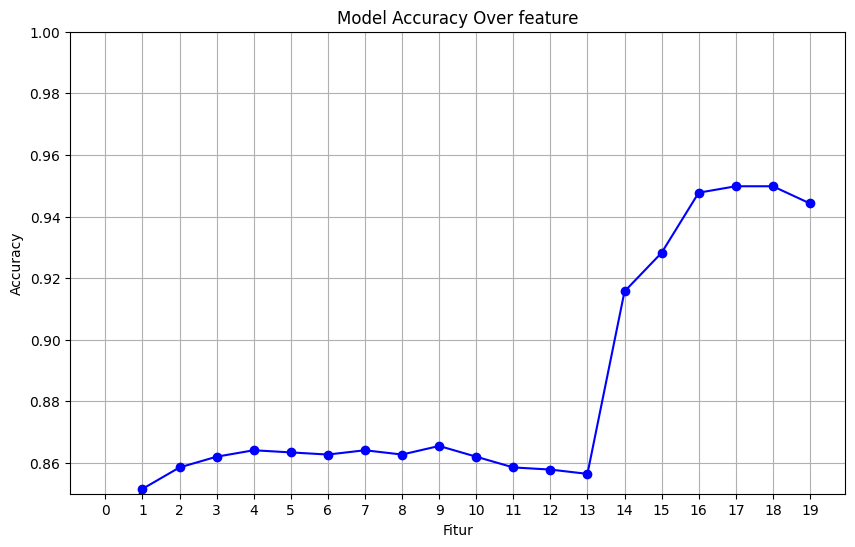

In [22]:

plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['Accuracy'], marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Over feature')
plt.xlabel('Fitur')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(history_df.index)  # Ensure all epochs are shown on the x-axis
plt.ylim(0.85, 1.0)  # Set y-axis limits for better visualization
plt.show()

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])
```
dan feature 'A/D_Oscillator', 'Stochastic_K', 'RSI', 'month', 'MACD_Signal', 'Williams_R', 'day', 'CCI', 'Stochastic_D', 'Volume', 'day_of_week', 'MACD', 'Momentum', 'Open', 'Close', 'High', 'Low', 'WMA', dengan nilai avg akurasi berupa 0.9498

# UHS

In [23]:
df_dict['UHS'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,110.745877,112.259221,109.960097,112.142807,754000,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,111.725667,111.725667,108.951199,109.998901,845900,0.0,0.0,0,3,...,NaN,NaN,NaN,NaN,NaN,-0.171024,-0.034205,NaN,-0.150350,NaN
2,2018-01-04 05:00:00+00:00,110.736183,110.736183,108.805699,109.416855,689000,0.0,0.0,0,4,...,NaN,NaN,NaN,NaN,NaN,-0.349499,-0.097264,NaN,0.381915,NaN
3,2018-01-05 05:00:00+00:00,110.037719,110.037719,107.418470,108.621384,1201800,0.0,0.0,0,5,...,NaN,NaN,NaN,NaN,NaN,-0.548803,-0.187572,NaN,0.237039,NaN
4,2018-01-08 05:00:00+00:00,108.446780,108.456483,105.982741,106.855827,1543500,0.0,0.0,0,8,...,NaN,NaN,NaN,NaN,NaN,-0.839541,-0.317966,NaN,-0.066660,NaN


In [24]:
X_train_uhs = df_dict['UHS'].dropna(subset=features)
X_train_uhs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   label           1722 non-null   int64              
 9   day             1722 non-null   int64              
 10  day_of_week     1722 non-null   int64              
 11  month           1722 non-null   int64              
 12  year            1722 non-null   int64              
 13  SMA             1722 non-null   

In [25]:
y_train = X_train_uhs['label']  
X_train = X_train_uhs.drop(columns=['label','Date','Dividends','Stock Splits'])

In [26]:
X_train

,Open,High,Low,Close,Volume,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,117.682047,118.244703,116.527641,116.673149,632800,29,0,1,2018,114.622378,115.319963,3.511726,75.602355,85.763259,71.496557,1.275739,0.632772,-24.397645,0.372884,114.356620
19,116.129899,122.047468,114.199415,118.865562,905300,30,1,1,2018,115.215105,116.091451,5.927269,67.811567,83.236541,79.234667,1.543063,0.814830,-32.188433,0.684796,155.009124
20,119.030488,119.176004,114.432246,117.866379,1124900,31,2,1,2018,115.743806,116.573501,5.287018,57.703739,80.140565,74.527696,1.655213,0.982907,-42.296261,0.065442,88.062908
21,117.371605,118.904354,115.673941,117.662636,594000,1,3,2,2018,116.128932,116.922379,3.851257,54.754509,75.718410,69.751305,1.707965,1.127918,-45.245491,0.321314,63.685367
22,116.818655,117.662639,114.810562,115.732155,637800,2,4,2,2018,116.246313,116.850238,1.173813,34.834577,71.023976,55.368263,1.575831,1.217501,-65.165423,0.000001,-23.033931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,195.759995,199.119995,194.990005,197.940002,1205700,22,4,11,2024,200.705000,198.963637,-9.559998,39.308756,41.883511,18.839697,-5.830037,-5.585553,-60.691244,0.365617,-58.611513
1736,196.720001,200.259995,195.350006,199.210007,713800,25,0,11,2024,199.770001,198.691820,-9.349991,48.731988,38.720801,19.935786,-5.573442,-5.583131,-51.268012,0.472505,-16.077939
1737,199.589996,206.710007,198.119995,206.089996,986700,26,1,11,2024,199.855000,199.840910,0.849991,94.826584,41.973857,52.223939,-4.760061,-5.418517,-5.173416,0.873107,171.479651
1738,206.009995,208.440002,202.059998,203.500000,566600,27,2,11,2024,199.930000,200.503637,0.750000,74.040973,44.503088,51.952106,-4.275159,-5.189845,-25.959027,0.368339,94.669901


In [27]:
y_train.value_counts()

1    902
0    820
Name: label, dtype: int64

In [29]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [30]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [31]:
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [192]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='Accuracy',  # Mengubah fitur utama untuk refit menjadi 'accuracy'
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_accuracy = grid_search.cv_results_['mean_test_Accuracy'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Accuracy': mean_accuracy,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")

Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [193]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result_2/UHS_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Accuracy  \
0  {'classifier__C': 0.001, 'classifier__penalty'...       0.478049   
1  {'classifier__C': 0.001, 'classifier__penalty'...       0.521951   
2  {'classifier__C': 0.001, 'classifier__penalty'...       0.765157   
3  {'classifier__C': 0.001, 'classifier__penalty'...       0.756098   
4  {'classifier__C': 0.01, 'classifier__penalty':...       0.767247   

   Mean Recall  Mean Precision  Mean F1 Score  
0     0.500000        0.239024       0.323254  
1     0.500000        0.260976       0.342788  
2     0.762173        0.765235       0.762923  
3     0.750317        0.770684       0.748646  
4     0.769077        0.718042       0.734547  


In [195]:
results_df['Mean Accuracy'].max()

0.9533101045296167

## feature selection

In [32]:
from sklearn.model_selection import cross_validate
import datetime

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])


def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_acc = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            accuracy = cv_results['test_Accuracy'].mean()
            if accuracy > best_acc:
                best_acc = accuracy
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': cv_results['test_F1_Score'].mean(),
                    'Accuracy':accuracy
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score'],
                'Accuracy': best_metrics['Accuracy']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | akurasi: {best_metrics['Accuracy']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

n_features_to_select = 20  # Tentukan jumlah fitur yang ingin dipilih
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result_2/UHS_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 20 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'A/D_Oscillator' | akurasi: 0.8411

Memilih fitur ke-2 dari 19 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'Stochastic_K' | akurasi: 0.8544

Memilih fitur ke-3 dari 18 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'day' | akurasi: 0.8557

Memilih fitur ke-4 dari 17 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'Momentum' | akurasi: 0.8578

Memilih fitur ke-5 dari 16 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'Williams_R' | akurasi: 0.8578

Memilih fitur ke-6 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'High' | akurasi: 0.8571

Memilih fitur ke-7 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'Close' | akurasi: 0.9010

Memilih fitur ke-8 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'Low' | akurasi: 0.9610

Memilih fitur ke-9 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'Open' | akurasi: 0.9638

Memilih f

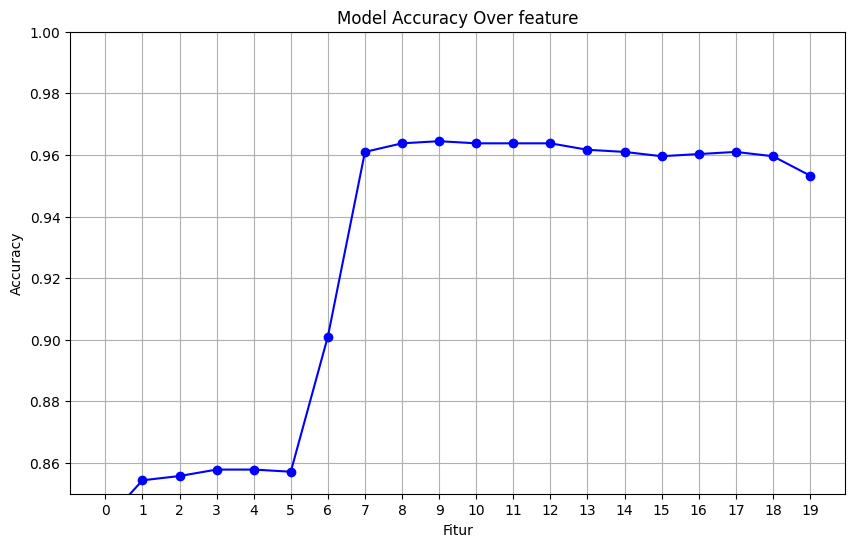

In [33]:

plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['Accuracy'], marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Over feature')
plt.xlabel('Fitur')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(history_df.index)  # Ensure all epochs are shown on the x-axis
plt.ylim(0.85, 1.0)  # Set y-axis limits for better visualization
plt.show()

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])
```
dan feature 'A/D_Oscillator', 'Stochastic_K', 'day', 'Momentum', 'Williams_R', 'High', 'Close', 'Low', 'Open','WMA' dengan nilai akurasi 0.9645

# BWA

In [34]:
df_dict['BWA'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,40.645727,40.993800,40.416312,40.962158,1348318,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,41.033342,41.231115,40.843484,41.167828,1343093,0.0,0.0,1,3,...,NaN,NaN,NaN,NaN,NaN,0.016407,0.003281,NaN,0.693847,NaN
2,2018-01-04 05:00:00+00:00,41.444706,42.749989,41.413061,42.504753,1924611,0.0,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,0.135723,0.029770,NaN,1.183430,NaN
3,2018-01-05 05:00:00+00:00,42.797464,43.794228,42.750002,43.738853,2501586,0.0,0.0,1,5,...,NaN,NaN,NaN,NaN,NaN,0.326105,0.089037,NaN,1.234861,NaN
4,2018-01-08 05:00:00+00:00,43.825856,44.094825,43.517337,43.762569,2122843,0.0,0.0,1,8,...,NaN,NaN,NaN,NaN,NaN,0.473440,0.165917,NaN,0.616414,NaN


In [35]:
X_train_BWA = df_dict['BWA'].dropna(subset=features)
X_train_BWA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   label           1722 non-null   int64              
 9   day             1722 non-null   int64              
 10  day_of_week     1722 non-null   int64              
 11  month           1722 non-null   int64              
 12  year            1722 non-null   int64              
 13  SMA             1722 non-null   

In [47]:
y_train = X_train_BWA['label']  
X_train = X_train_BWA.drop(columns=['label','Date','Dividends','Stock Splits'])

In [48]:
X_train

,Open,High,Low,Close,Volume,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,45.059953,45.669083,44.941291,44.949200,1188142,29,0,1,2018,44.921514,44.878580,-0.324337,46.565005,64.452952,46.917341,0.901353,0.923845,-53.434995,0.619557,5.789516
19,44.759345,45.241904,44.561575,44.870094,1068067,30,1,1,2018,44.953157,44.869231,0.316429,42.748352,61.036593,53.424629,0.859807,0.911037,-57.251648,0.430239,-19.230484
20,45.162791,45.415935,44.332155,44.506191,1254371,31,2,1,2018,44.822628,44.787964,-1.305286,25.781280,54.085131,32.484052,0.788428,0.886515,-74.218720,0.503645,-87.146903
21,44.086915,44.790977,43.675554,44.609028,1152586,1,3,2,2018,44.765669,44.749128,-0.569588,46.825191,50.658614,41.088966,0.731723,0.855557,-53.174809,0.255316,-45.835189
22,44.229316,44.498285,43.018961,43.090160,1402619,2,4,2,2018,44.570272,44.444490,-1.953968,2.686637,43.989489,28.670096,0.557795,0.796005,-97.313363,-0.074861,-275.471547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,33.619999,34.250000,33.619999,34.119999,1681100,22,4,11,2024,34.224000,33.987273,0.200001,42.905379,46.841017,52.293588,-0.118963,-0.051750,-57.094621,0.777779,-13.457712
1736,34.459999,35.520000,34.459999,35.180000,2370600,25,0,11,2024,34.276000,34.161091,0.520000,78.716201,47.970698,55.555565,-0.020883,-0.045577,-21.283799,1.320754,108.237514
1737,34.650002,34.849998,33.900002,34.169998,2298700,26,1,11,2024,34.179000,34.141818,-0.970001,44.594541,44.139826,40.690966,-0.024372,-0.041336,-55.405459,-0.347371,-1.247666
1738,34.290001,34.750000,34.189999,34.279999,1220700,27,2,11,2024,34.126000,34.160181,-0.530003,53.558024,42.582046,44.689355,-0.018053,-0.036679,-46.441976,1.035715,23.504117


In [49]:
y_train.value_counts()

1    870
0    852
Name: label, dtype: int64

In [50]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [51]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier( eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [52]:
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [53]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='Accuracy',  # Mengubah fitur utama untuk refit menjadi 'accuracy'
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_accuracy = grid_search.cv_results_['mean_test_Accuracy'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Accuracy': mean_accuracy,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")

Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [58]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result_2/BWA_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Accuracy  \
0  {'classifier__C': 0.001, 'classifier__penalty'...       0.492683   
1  {'classifier__C': 0.001, 'classifier__penalty'...       0.499652   
2  {'classifier__C': 0.001, 'classifier__penalty'...       0.758885   
3  {'classifier__C': 0.001, 'classifier__penalty'...       0.754704   
4  {'classifier__C': 0.01, 'classifier__penalty':...       0.849477   

   Mean Recall  Mean Precision  Mean F1 Score  
0     0.500000        0.246341       0.329912  
1     0.500000        0.249826       0.333012  
2     0.758708        0.760697       0.758068  
3     0.754786        0.755050       0.754241  
4     0.848709        0.849721       0.848978  


In [57]:
results_df['Mean Accuracy'].max()

0.9637630662020905

## feature selection

In [60]:
from sklearn.model_selection import cross_validate
import datetime

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])

def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_acc = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            accuracy = cv_results['test_Accuracy'].mean()
            if accuracy > best_acc:
                best_acc = accuracy
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': cv_results['test_F1_Score'].mean(),
                    'Accuracy':accuracy
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score'],
                'Accuracy': best_metrics['Accuracy']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | akurasi: {best_metrics['Accuracy']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

n_features_to_select = 20  # Tentukan jumlah fitur yang ingin dipilih
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result_2/BWA_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 20 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'A/D_Oscillator' | akurasi: 0.8509

Memilih fitur ke-2 dari 19 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'Stochastic_K' | akurasi: 0.8641

Memilih fitur ke-3 dari 18 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'Stochastic_D' | akurasi: 0.8690

Memilih fitur ke-4 dari 17 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'Volume' | akurasi: 0.8697

Memilih fitur ke-5 dari 16 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'year' | akurasi: 0.8704

Memilih fitur ke-6 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'month' | akurasi: 0.8746

Memilih fitur ke-7 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'Williams_R' | akurasi: 0.8746

Memilih fitur ke-8 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'SMA' | akurasi: 0.8718

Memilih fitur ke-9 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'Open' | akurasi: 0.8871

Me

In [61]:
history_df['Accuracy'].max()

0.9665505226480835

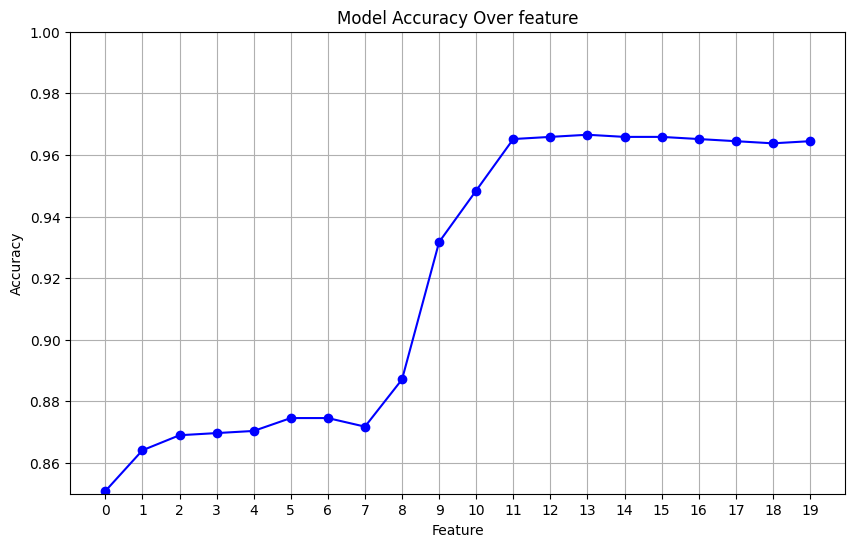

In [62]:

plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['Accuracy'], marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Over feature')
plt.xlabel('Feature')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(history_df.index)  # Ensure all epochs are shown on the x-axis
plt.ylim(0.85, 1.0)  # Set y-axis limits for better visualization
plt.show()

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=10,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])
```
dan feature 'A/D_Oscillator', 'Stochastic_K', 'Stochastic_D', 'Volume', 'year', 'month', 'Williams_R', 'SMA', 'Open', 'Close', 'High', 'Low', 'day_of_week', 'WMA' dengan nilai avg akurasi berupa 0.9665

# MRO

In [63]:
df_dict['MRO'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,15.553840,15.808373,15.490207,15.799282,8107020,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,15.862918,16.244719,15.844736,16.062908,10684677,0.0,0.0,1,3,...,NaN,NaN,NaN,NaN,NaN,0.021030,0.004206,NaN,1.113641,NaN
2,2018-01-04 05:00:00+00:00,16.271989,16.499251,16.020910,16.471981,14052092,0.0,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,0.069899,0.017345,NaN,0.912201,NaN
3,2018-01-05 05:00:00+00:00,16.326533,16.326533,16.026546,16.262899,11962183,0.0,0.0,0,5,...,NaN,NaN,NaN,NaN,NaN,0.090712,0.032018,NaN,-0.484850,NaN
4,2018-01-08 05:00:00+00:00,16.244721,16.344715,16.044729,16.335625,7096781,0.0,0.0,1,8,...,NaN,NaN,NaN,NaN,NaN,0.111786,0.047972,NaN,0.272732,NaN


In [64]:
X_train_MRO = df_dict['MRO'].dropna(subset=features)
X_train_MRO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 18 to 1734
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1717 non-null   datetime64[ns, UTC]
 1   Open            1717 non-null   float64            
 2   High            1717 non-null   float64            
 3   Low             1717 non-null   float64            
 4   Close           1717 non-null   float64            
 5   Volume          1717 non-null   int64              
 6   Dividends       1717 non-null   float64            
 7   Stock Splits    1717 non-null   float64            
 8   label           1717 non-null   int64              
 9   day             1717 non-null   int64              
 10  day_of_week     1717 non-null   int64              
 11  month           1717 non-null   int64              
 12  year            1717 non-null   int64              
 13  SMA             1717 non-null   

In [65]:
y_train = X_train_MRO['label']  
X_train = X_train_MRO.drop(columns=['label','Date','Dividends','Stock Splits'])

In [66]:
X_train

,Open,High,Low,Close,Volume,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,16.935597,17.335579,16.826512,16.926508,7613634,29,0,1,2018,17.114679,17.159388,-0.181805,37.931087,69.839092,46.913677,0.323661,0.322505,-62.068913,0.410712,-52.074871
19,16.771967,16.808328,16.099269,16.417437,12467494,30,1,1,2018,17.098317,17.032617,-0.163628,19.337009,65.511056,47.205002,0.253890,0.308782,-80.662991,-0.166671,-176.443182
20,16.417438,16.635610,16.335624,16.535616,9760274,31,2,1,2018,17.039228,16.930308,-0.590883,26.519493,59.405244,38.181839,0.205761,0.288178,-73.480507,0.727278,-112.327434
21,16.590157,16.835601,16.508342,16.753786,9494424,1,3,2,2018,17.015593,16.878409,-0.236353,39.779035,55.854569,45.422542,0.183111,0.267164,-60.220965,0.916660,-54.920047
22,16.490162,16.571976,15.835737,15.926552,10885077,2,4,2,2018,16.919234,16.680402,-0.963594,4.757424,49.592720,35.439559,0.097289,0.233189,-95.242576,-0.246944,-161.921622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,28.790001,29.059999,28.485001,28.590000,5087537,15,4,11,2024,28.298632,28.461507,1.423977,72.747707,82.534753,74.388152,0.418430,0.249843,-27.252293,0.556522,54.441035
1731,28.910000,29.129999,28.719999,28.990000,5382254,18,0,11,2024,28.457121,28.587210,1.584890,92.198951,83.746170,75.726096,0.458343,0.291543,-7.801049,1.317071,137.778152
1732,28.750000,29.045000,28.610001,28.750000,4249408,19,1,11,2024,28.582644,28.640461,1.255234,70.233658,82.379701,69.426897,0.465245,0.326283,-29.766342,0.126438,65.864665
1733,28.770000,29.000099,28.670000,28.920000,3671800,20,2,11,2024,28.605625,28.701798,0.229811,83.550215,81.583644,55.210569,0.478912,0.356809,-16.449785,0.757649,107.203834


In [67]:
y_train.value_counts()

1    877
0    840
Name: label, dtype: int64

In [68]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [69]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier( eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [70]:
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [71]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='Accuracy',  # Mengubah fitur utama untuk refit menjadi 'accuracy'
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_accuracy = grid_search.cv_results_['mean_test_Accuracy'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Accuracy': mean_accuracy,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")

Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [72]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result_2/MRO_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Accuracy  \
0  {'classifier__C': 0.001, 'classifier__penalty'...       0.492308   
1  {'classifier__C': 0.001, 'classifier__penalty'...       0.483916   
2  {'classifier__C': 0.001, 'classifier__penalty'...       0.765035   
3  {'classifier__C': 0.001, 'classifier__penalty'...       0.759441   
4  {'classifier__C': 0.01, 'classifier__penalty':...       0.853846   

   Mean Recall  Mean Precision  Mean F1 Score  
0     0.500000        0.246154       0.329770  
1     0.500000        0.241958       0.326038  
2     0.762788        0.767597       0.763051  
3     0.758827        0.760609       0.758585  
4     0.852866        0.854681       0.853304  


In [74]:
results_df['Mean Accuracy'].max()

0.941958041958042

## feature selection

In [75]:
from sklearn.model_selection import cross_validate
import datetime

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=100,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])


def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_acc = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            accuracy = cv_results['test_Accuracy'].mean()
            if accuracy > best_acc:
                best_acc = accuracy
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': cv_results['test_F1_Score'].mean(),
                    'Accuracy':accuracy
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score'],
                'Accuracy': best_metrics['Accuracy']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | akurasi: {best_metrics['Accuracy']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

n_features_to_select = 20  # Tentukan jumlah fitur yang ingin dipilih
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result_2/MRO_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 20 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'A/D_Oscillator' | akurasi: 0.8538

Memilih fitur ke-2 dari 19 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'Stochastic_K' | akurasi: 0.8594

Memilih fitur ke-3 dari 18 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'Stochastic_D' | akurasi: 0.8650

Memilih fitur ke-4 dari 17 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'MACD_Signal' | akurasi: 0.8727

Memilih fitur ke-5 dari 16 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'day_of_week' | akurasi: 0.8741

Memilih fitur ke-6 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'Close' | akurasi: 0.8741

Memilih fitur ke-7 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'Low' | akurasi: 0.9105

Memilih fitur ke-8 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'High' | akurasi: 0.9531

Memilih fitur ke-9 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'SMA' | akurasi: 0.956

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=100,
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])
```
dan feature 'A/D_Oscillator', 'Stochastic_K', 'Stochastic_D', 'MACD_Signal', 'day_of_week', 'Close', 'Low', 'High', 'SMA', 'WMA', 'Volume', dengan nilai avg accuracy berupa 0.9594